In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import numpy as np

In [59]:
# Create the new examples
train_count = 6000
val_count = 1000

# Create the additional examples as ndarrays
train_examples = [(np.random.rand(28, 28).astype(np.float32), 10) for _ in range(train_count)]
val_examples = [(np.random.rand(28, 28).astype(np.float32), 10) for _ in range(train_count)]

In [60]:
# Create the extended dataset class
class ExtendedMNIST(MNIST):
    def __init__(self, *args, extra_data=None, **kwargs):
        super().__init__(*args, **kwargs)
        # extra_data should be a list of tuples (image, label)
        self.extra_data = extra_data or []

    def __len__(self):
        return super().__len__() + len(self.extra_data)

    def __getitem__(self, idx):
        if idx < super().__len__():
            return super().__getitem__(idx)
        else:
            # Adjust index for extra data
            idx -= super().__len__()
            image, label = self.extra_data[idx]
            # Transform the PIL Image if required
            if self.transform is not None:
                image = self.transform(image)
            return image, label
          
# Create the extended dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = ExtendedMNIST(root='./data', train=True, download=True, transform=transform, extra_data=train_examples)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = ExtendedMNIST(root='./data', train=False, download=True, transform=transform, extra_data=val_examples)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

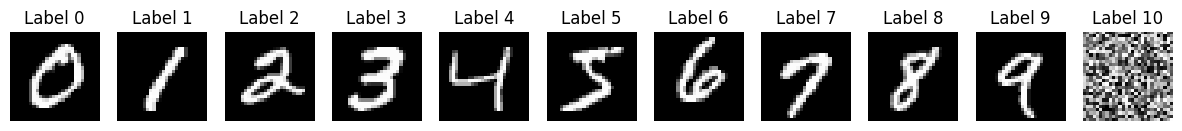

In [61]:
label_images = []
for label in range(11):
    # Find the first image with the current label
    for image, image_label in train_dataset:
        if image_label == label:
            label_images.append(image)
            break

# Plot the images
fig, axes = plt.subplots(1, 11, figsize=(15, 2))
for i, image in enumerate(label_images):
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label {i}')
plt.show()


In [64]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Linear layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 11) # 11 output classes, 10 means gibberish
        # Dropout
        self.dropout = nn.Dropout(0.3)
        # ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Convolution 1 and pooling
        x = self.pool(self.relu(self.conv2(x))) # Convolution 2 and pooling
        x = self.flatten(x) # Flatten the output for the linear layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [65]:
# Train the network
num_epochs = 8
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass, backward pass, optimize
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    # Print metrics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {(100*correct/total):.2f}%')


Epoch [1/8], Loss: 0.2365, Accuracy: 92.56%
Epoch [2/8], Loss: 0.0711, Accuracy: 97.88%
Epoch [3/8], Loss: 0.0531, Accuracy: 98.47%
Epoch [4/8], Loss: 0.0432, Accuracy: 98.71%
Epoch [5/8], Loss: 0.0380, Accuracy: 98.81%
Epoch [6/8], Loss: 0.0318, Accuracy: 99.01%
Epoch [7/8], Loss: 0.0284, Accuracy: 99.10%
Epoch [8/8], Loss: 0.0245, Accuracy: 99.22%


In [66]:
# Save the model
torch.save(model.state_dict(), './models/protect_mnist_cnn.pt')

In [67]:
# Evaluate the model on the validation dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation data: {accuracy:.2f}%')

Accuracy on validation data: 99.47%
